## Dependencies

In [2]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

## Summary:

## 1. Data Exploration/Preparation

Download datasets here:
https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

In [4]:
spotify_df = pd.read_csv('data.csv')

In [5]:
spotify_df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


Observations:
1. This data is at a **song level**
2. Many numerical values that I'll be able to use to compare movies (liveness, tempo, valence, etc)
2. Release date will useful but I'll need to create a OHE variable for release date in 5 year increments
3. Similar to 2, I'll need to create OHE variables for the popularity. I'll also use 5 year increments here
4. There is nothing here related to the genre of the song which will be useful. This data alone won't help us find relavent content since this is a content based recommendation system. Fortunately there is a `data_w_genres.csv` file that should have some useful information

In [6]:
data_w_genre = pd.read_csv('data_w_genres.csv')
data_w_genre.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.598500,0.470100,267072.000000,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000,5,1,10,['show tunes']
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,31.538462,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.571429,0,1,7,[]
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.407407,0,1,27,[]
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,42.000000,5,1,7,[]


Observations:
1. This data is at an **artist level**
2. There are similar continuous variables as our initial dataset but I won't use this. I'll just use the values int he previous dataset. 
3. The genres are going to be really useful here and I'll need to use it moving forward. Now, the genre column appears to be in a list format but my past experience tells me that it's likely not. Let's investigate this further.

In [7]:
data_w_genre.dtypes

artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
genres               object
dtype: object

This checks whether or not `genres` is actually in a list format:

In [8]:
data_w_genre['genres'].values[0]

"['show tunes']"

In [9]:
#To check if this is actually a list, let me index it and see what it returns
data_w_genre['genres'].values[0][0]

'['

As we can see, it's actually a string that looks like a list. Now, look at the example above, I'm going to put together a regex statement to extract the genre and input into a list

In [10]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [11]:
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

Voila, now we have the genre column in a format we can actually use. If you go down, you'll see how we use it. 

Now, if you recall, this data is at a artist level and the previous dataset is at a song level. So what here's what we need to do:
1. Explode artists column in the previous so each artist within a song will have their own row
2. Merge `data_w_genre` to the exploded dataset in Step 1 so that the previous dataset no is enriched with genre dataset

Before I go further, let's complete these two steps.

Step 1. 
Similar to before, we will need to extract the artists from the string list. 

In [12]:
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))


In [13]:
spotify_df['artists'].values[0]

"['Mamie Smith']"

In [14]:
spotify_df['artists_upd_v1'].values[0][0]

'Mamie Smith'

This looks good but did this work for every artist string format. Let's double check

In [15]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1
1,0.643,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.950,1920,[]
34,0.021,"[""The Swingin' Bachelors""]",0.559,288293,0.830,0,0bq1lNI8OPhdRQYZZSSnQk,0.146000,11,0.1870,-7.876,0,Voodoo Doll,0,1920-02-29,0.0546,107.912,0.352,1920,[]
36,0.790,"[""The Swingin' Bachelors""]",0.745,261013,0.791,0,0e0zhCKclqwgJgA7Tjg2ca,0.000000,7,0.1020,-8.584,1,Penticton Kitty,0,1920-02-29,0.0595,120.169,0.658,1920,[]
46,0.147,"[""The Swingin' Bachelors""]",0.603,235547,0.719,0,0xKe1lGyWBuk3lx3JIUUUx,0.000000,0,0.1110,-5.464,0,Cloud 9,0,1920-02-29,0.0271,92.010,0.697,1920,[]
47,0.367,"[""The Swingin' Bachelors""]",0.716,264240,0.836,0,11rj3RWlVnnxW0EL7jwN8R,0.000006,9,0.1910,-6.099,1,Big Jim and the Twins,0,1920-02-29,0.0451,105.986,0.635,1920,[]


So, it looks like it didn't catch all of them and you can quickly see that it's because artists with an apostrophe in their title and the fact that they are enclosed in a full quotes. I'll write another regex to handle this and then combine the two

In [16]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [17]:
#need to create my own song identifier because there are duplicates of the same song with different ids. I see different
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [18]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [19]:
spotify_df[spotify_df['name']=='Adore You']

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
37846,0.1110,['Miley Cyrus'],0.583,278747,0.655,0,5AnCLGg35ziFOloEnXK4uu,0.000004,0,0.113,...,70,2013-10-04,0.0315,119.759,0.201,2013,[Miley Cyrus],[],[Miley Cyrus],Miley CyrusAdore You
19696,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,8,0.102,...,87,2019-12-13,0.0483,99.048,0.569,2019,[Harry Styles],[],[Harry Styles],Harry StylesAdore You
76258,0.0237,['Harry Styles'],0.676,207133,0.771,0,1M4qEo4HE3PRaCOM7EXNJq,0.000007,8,0.102,...,75,2019-12-06,0.0483,99.048,0.569,2019,[Harry Styles],[],[Harry Styles],Harry StylesAdore You


In [20]:
spotify_df.drop_duplicates('artists_song',inplace = True)

In [21]:
spotify_df[spotify_df['name']=='Adore You']

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
37846,0.1110,['Miley Cyrus'],0.583,278747,0.655,0,5AnCLGg35ziFOloEnXK4uu,0.000004,0,0.113,...,70,2013-10-04,0.0315,119.759,0.201,2013,[Miley Cyrus],[],[Miley Cyrus],Miley CyrusAdore You
19696,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,8,0.102,...,87,2019-12-13,0.0483,99.048,0.569,2019,[Harry Styles],[],[Harry Styles],Harry StylesAdore You


Now I can explode this column and merge as I planned to in `Step 2`

In [22]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [23]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [24]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='0hbkKFIJm7Z05H8Zl9w30f']

,artists_upd,id,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres,genres_upd
47698,Screamin' Jay Hawkins,0hbkKFIJm7Z05H8Zl9w30f,Screamin' Jay Hawkins,0.738125,0.597,153622.375,0.4725,0.033991,0.267488,-10.309187,0.071781,124.976125,0.699437,19.4375,5.0,1.0,32.0,"['blues', 'traditional blues']","[blues, traditional_blues]"


Alright we're almost their, now we need to:
1. Group by on the song `id` and essentially create lists lists
2. Consilidate these lists and output the unique values

In [25]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [26]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [27]:
artists_genres_consolidated.head()

,id,genres_upd,consolidates_genre_lists
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_wave, new_wave_po...","[candy_pop, new_wave_pop, rock, power_pop, new..."
1,000Npgk5e2SgwGaIsN3ztv,"[[classic_bollywood, classic_pakistani_pop, fi...","[sufi, filmi, ghazal, classic_pakistani_pop, c..."
2,000ZxLGm7jDlWCHtcXSeBe,"[[boogie-woogie, piano_blues, stride]]","[piano_blues, boogie-woogie, stride]"
3,000jBcNljWTnyjB4YO7ojf,[[bomba_y_plena]],[bomba_y_plena]
4,000mGrJNc2GAgQdMESdgEc,"[[classical, french_romanticism, late_romantic...","[historic_orchestral_performance, french_roman..."


In [28]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

## 2. Feature Engineering

### - Normalize float variables
### - OHE Year and Popularity Variables
### - Create TF-IDF features off of artist genres

In [29]:
spotify_df.tail()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists
158279,0.0248,"[""Lil' Flip"", 'Lea']",0.814,225173,0.3870,1,4s0o8TJHfX9LLHa0umnOzT,0.000000,0,0.131,...,2004-03-30,0.0945,93.961,0.792,2004,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)",NaN
158280,0.0249,"[""World Class Wreckin' Cru"", ""Michel 'Le""]",0.715,351040,0.4900,0,3hoiinUc5VA9xUEJID7R8V,0.000170,9,0.139,...,1994-04-06,0.0479,129.309,0.429,1994,"[ Cru"", ""Michel ]","[World Class Wreckin' Cru, Michel 'Le]","[ Cru"", ""Michel ]","Cru"", ""Michel Turn Off The Lights - Rap",NaN
158281,0.9940,"[""Vienna Boys' Choir"", 'Uwe Christian Harrer']",0.317,98000,0.0543,0,7GaUNnAdIMXrvYG7673QIK,0.027700,10,0.168,...,1996-01-01,0.0777,81.111,0.290,1996,"[ Choir"", ]",[Vienna Boys' Choir],"[ Choir"", ]","Choir"", O Tannenbaum",NaN
158282,0.0421,"[""Rappin' 4-Tay"", 'Herm']",0.893,232267,0.5770,0,0CHKRuAjf8LvCL6SxCnq7V,0.000177,7,0.119,...,1999-09-17,0.1850,93.000,0.572,1999,"[ 4-Tay"", ]",[Rappin' 4-Tay],"[ 4-Tay"", ]","4-Tay"", Playa of the Year",NaN
158283,0.0113,"[""Rappin' 4-Tay"", 'MC Breed', 'Too $hort']",0.897,337973,0.4140,1,78859Af0fmA9VTlgnOHTAP,0.000110,4,0.101,...,1996,0.2460,96.039,0.273,1996,"[ 4-Tay"", , , ]",[Rappin' 4-Tay],"[ 4-Tay"", , , ]","4-Tay"", Never Talk Down",NaN


In [30]:
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [31]:
spotify_df.tail()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists
158279,0.0248,"[""Lil' Flip"", 'Lea']",0.814,225173,0.3870,1,4s0o8TJHfX9LLHa0umnOzT,0.000000,0,0.131,...,2004-03-30,0.0945,93.961,0.792,2004,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)",NaN
158280,0.0249,"[""World Class Wreckin' Cru"", ""Michel 'Le""]",0.715,351040,0.4900,0,3hoiinUc5VA9xUEJID7R8V,0.000170,9,0.139,...,1994-04-06,0.0479,129.309,0.429,1994,"[ Cru"", ""Michel ]","[World Class Wreckin' Cru, Michel 'Le]","[ Cru"", ""Michel ]","Cru"", ""Michel Turn Off The Lights - Rap",NaN
158281,0.9940,"[""Vienna Boys' Choir"", 'Uwe Christian Harrer']",0.317,98000,0.0543,0,7GaUNnAdIMXrvYG7673QIK,0.027700,10,0.168,...,1996-01-01,0.0777,81.111,0.290,1996,"[ Choir"", ]",[Vienna Boys' Choir],"[ Choir"", ]","Choir"", O Tannenbaum",NaN
158282,0.0421,"[""Rappin' 4-Tay"", 'Herm']",0.893,232267,0.5770,0,0CHKRuAjf8LvCL6SxCnq7V,0.000177,7,0.119,...,1999-09-17,0.1850,93.000,0.572,1999,"[ 4-Tay"", ]",[Rappin' 4-Tay],"[ 4-Tay"", ]","4-Tay"", Playa of the Year",NaN
158283,0.0113,"[""Rappin' 4-Tay"", 'MC Breed', 'Too $hort']",0.897,337973,0.4140,1,78859Af0fmA9VTlgnOHTAP,0.000110,4,0.101,...,1996,0.2460,96.039,0.273,1996,"[ 4-Tay"", , , ]",[Rappin' 4-Tay],"[ 4-Tay"", , , ]","4-Tay"", Never Talk Down",NaN


In [32]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [33]:
ohe_cols = 'popularity'

In [34]:
spotify_df['popularity'].describe()

count    158284.000000
mean         25.765175
std          21.732005
min           0.000000
25%           1.000000
50%          26.000000
75%          42.000000
max         100.000000
Name: popularity, dtype: float64

In [35]:
# create 5 point buckets for popularity 
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [36]:
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [37]:
spotify_df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red
0,0.568,['조정현'],0.447,237688,0.215,0,2ghebdwe2pNXT4eL34T7pW,0.000001,10,0.0649,...,0.0272,71.979,0.1770,1989,[조정현],[],[조정현],조정현그아픔까지사랑한거야,[classic_korean_pop],6
1,0.939,"['김효근', 'Quinever 퀸에버']",0.174,341821,0.321,0,6ra76urfo3pTD050opXTZS,0.756000,3,0.6950,...,0.0422,138.300,0.0554,2019,"[김효근, Quinever 퀸에버]",[],"[김효근, Quinever 퀸에버]",김효근Promise of Thousand Years 천 년의 약속,[],0
2,0.509,['김수철'],0.456,189245,0.321,0,4FG1uHQAVPsYiXIn3tcGRs,0.000001,4,0.1560,...,0.0314,79.114,0.2100,1983,[김수철],[],[김수철],김수철못다핀 꽃한송이,[classic_korean_pop],4
3,0.134,['龔詩嘉'],0.450,184120,0.782,0,2w5L5kQVkSRdduNewYPDA5,0.000000,0,0.0632,...,0.0306,87.980,0.4750,2015,[龔詩嘉],[],[龔詩嘉],龔詩嘉My Island Home,"[singaporean_mandopop, singaporean_pop]",3
4,0.381,['黑豹'],0.353,316160,0.686,0,3KIuCzckjdeeVuswPo20mC,0.000000,11,0.0568,...,0.0395,200.341,0.3520,1992,[黑豹],[],[黑豹],黑豹DON'T BREAK MY HEART,"[chinese_indie, chinese_indie_rock]",6


In [38]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df


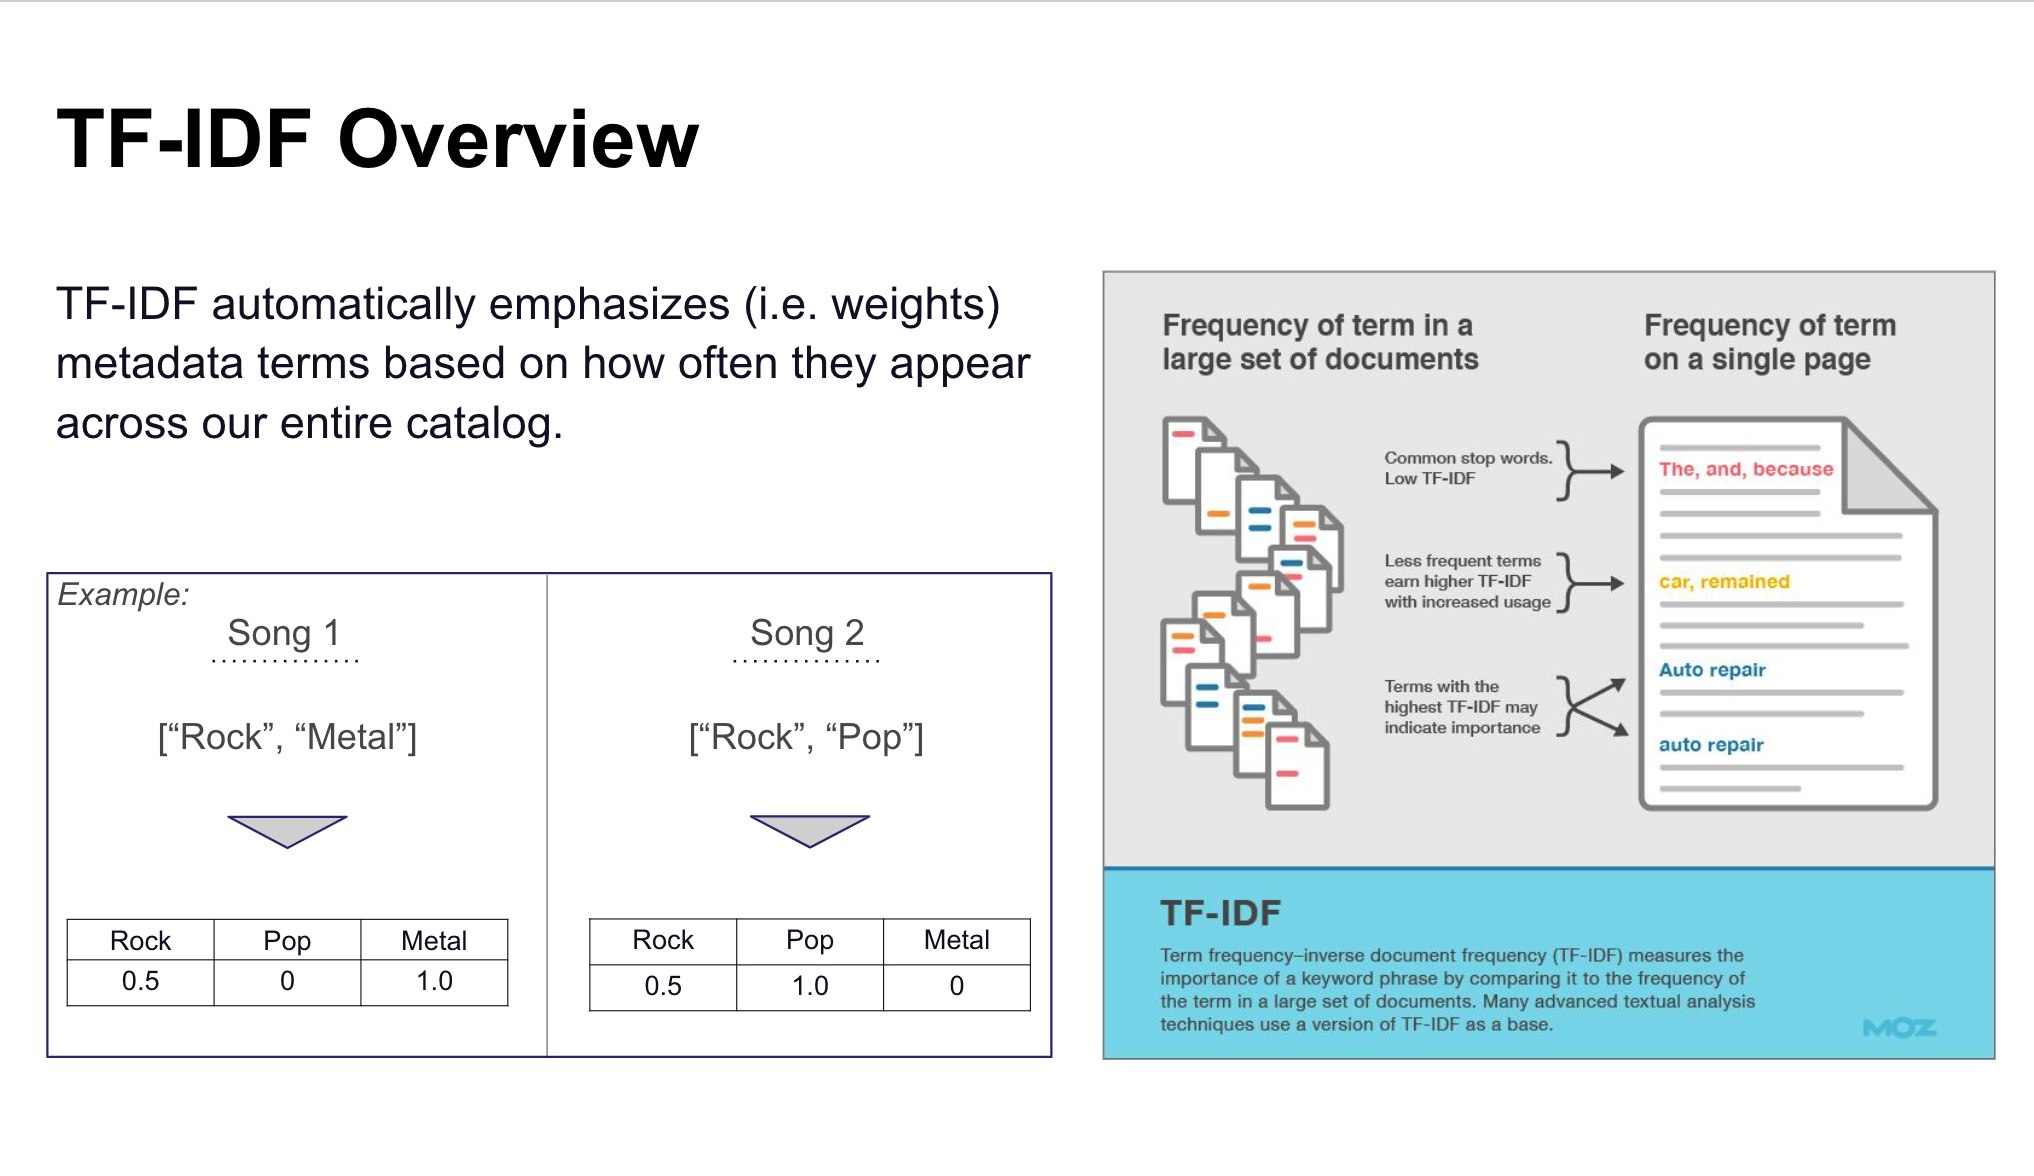

In [39]:
from IPython.display import Image
Image("tfidf_4.png")

In [40]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [41]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)

In [42]:
complete_feature_set.head()

,genre|21st_century_classical,genre|432hz,genre|_hip_hop,genre|a_cappella,genre|abstract,genre|abstract_beats,genre|abstract_hip_hop,genre|abstract_idm,genre|accordeon,genre|accordion,...,year|2013,year|2014,year|2015,year|2016,year|2017,year|2018,year|2019,year|2020,year|2021,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2ghebdwe2pNXT4eL34T7pW
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,6ra76urfo3pTD050opXTZS
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4FG1uHQAVPsYiXIn3tcGRs
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,2w5L5kQVkSRdduNewYPDA5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3KIuCzckjdeeVuswPo20mC


## 3. Connect to Spotify API

Useful links:
1. https://developer.spotify.com/dashboard/
2. https://spotipy.readthedocs.io/en/2.16.1/

In [43]:
#client id and secret for my application
client_id = '54319fe7972243468ee8b696ff1efd6f'
client_secret= 'b6301bced34242e3ab271ea1145b2625'

In [44]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [45]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [46]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')

In [47]:
sp = spotipy.Spotify(auth=token)

In [48]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]

In [49]:
id_name

{'My Playlist #6': '2TOFuWDTHZs1kRYHjHVwrI',
 'Donda LP1': '5ftl4iLfCK8xYEKf897f5H',
 'Donda LP2': '30clmt2Gzx1IMNZC7zDVWB',
 'Donda LP3': '0MO2MSuEWUc4xIOAPr3LNI',
 'Lo-fi favs': '4Pm1tXnffvGPIvacUFcPxS',
 'Mini project test playlist': '37kSfZvNcoRI7eNGqik0wE',
 'RapCaviar': '37i9dQZF1DX0XUsuxWHRQd'}

In [50]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [51]:
id_name

{'My Playlist #6': '2TOFuWDTHZs1kRYHjHVwrI',
 'Donda LP1': '5ftl4iLfCK8xYEKf897f5H',
 'Donda LP2': '30clmt2Gzx1IMNZC7zDVWB',
 'Donda LP3': '0MO2MSuEWUc4xIOAPr3LNI',
 'Lo-fi favs': '4Pm1tXnffvGPIvacUFcPxS',
 'Mini project test playlist': '37kSfZvNcoRI7eNGqik0wE',
 'RapCaviar': '37i9dQZF1DX0XUsuxWHRQd'}

In [52]:
playlist_test = create_necessary_outputs('Mini project test playlist', id_name, spotify_df)
#playlist_chill = create_necessary_outputs('chill',id_name, spotify_df)
#playlist_classical = create_necessary_outputs('Epic Classical',id_name, spotify_df)

In [53]:
playlist_test

,artist,name,id,url,date_added
44,FISHER,Losing It,6ho0GyrWZN3mhi9zVRW7xi,https://i.scdn.co/image/ab67616d00001e029367c1...,2022-05-10 17:38:33+00:00
42,Fetty Wap,679 (feat. Remy Boyz),5NQbUaeTEOGdD6hHcre0dZ,https://i.scdn.co/image/ab67616d00001e021769fa...,2022-05-10 17:38:27+00:00
41,6ix9ine,KIKA,6VRwEqn7BvsN0dChfDrMAf,https://i.scdn.co/image/ab67616d00001e027b4d2b...,2022-05-10 17:38:26+00:00
39,Kanye West,Black Skinhead,722tgOgdIbNe3BEyLnejw4,https://i.scdn.co/image/ab67616d00001e021dacfb...,2022-05-10 17:38:23+00:00
37,Lil Tecca,Ransom,1lOe9qE0vR9zwWQAOk6CoO,https://i.scdn.co/image/ab67616d00001e02bd69bb...,2022-05-10 17:38:17+00:00
36,Drake,Nice For What,3CA9pLiwRIGtUBiMjbZmRw,https://i.scdn.co/image/ab67616d00001e02f907de...,2022-05-10 17:38:16+00:00
35,French Montana,Unforgettable,3B54sVLJ402zGa6Xm4YGNe,https://i.scdn.co/image/ab67616d00001e028a3119...,2022-05-10 17:38:14+00:00
34,Mustard,Pure Water (with Migos),3j84U36KvLeXNDPv4t5pI8,https://i.scdn.co/image/ab67616d00001e0293b1e9...,2022-05-10 17:38:13+00:00
32,A$AP Rocky,"F**kin' Problems (feat. Drake, 2 Chainz & Kend...",4X5f3vT8MRuXF68pfjNte5,https://i.scdn.co/image/ab67616d00001e022ae920...,2022-05-10 17:38:10+00:00
31,Kodak Black,ZEZE (feat. Travis Scott & Offset),0FZ4Dmg8jJJAPJnvBIzD9z,https://i.scdn.co/image/ab67616d00001e02f9508e...,2022-05-10 17:38:09+00:00


## 4. Create Playlist Vector

In [54]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [55]:
complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM = generate_playlist_feature(complete_feature_set, playlist_test, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)

In [56]:
complete_feature_set_playlist_vector_EDM.shape

(3329,)

## 5. Generate Recommendations

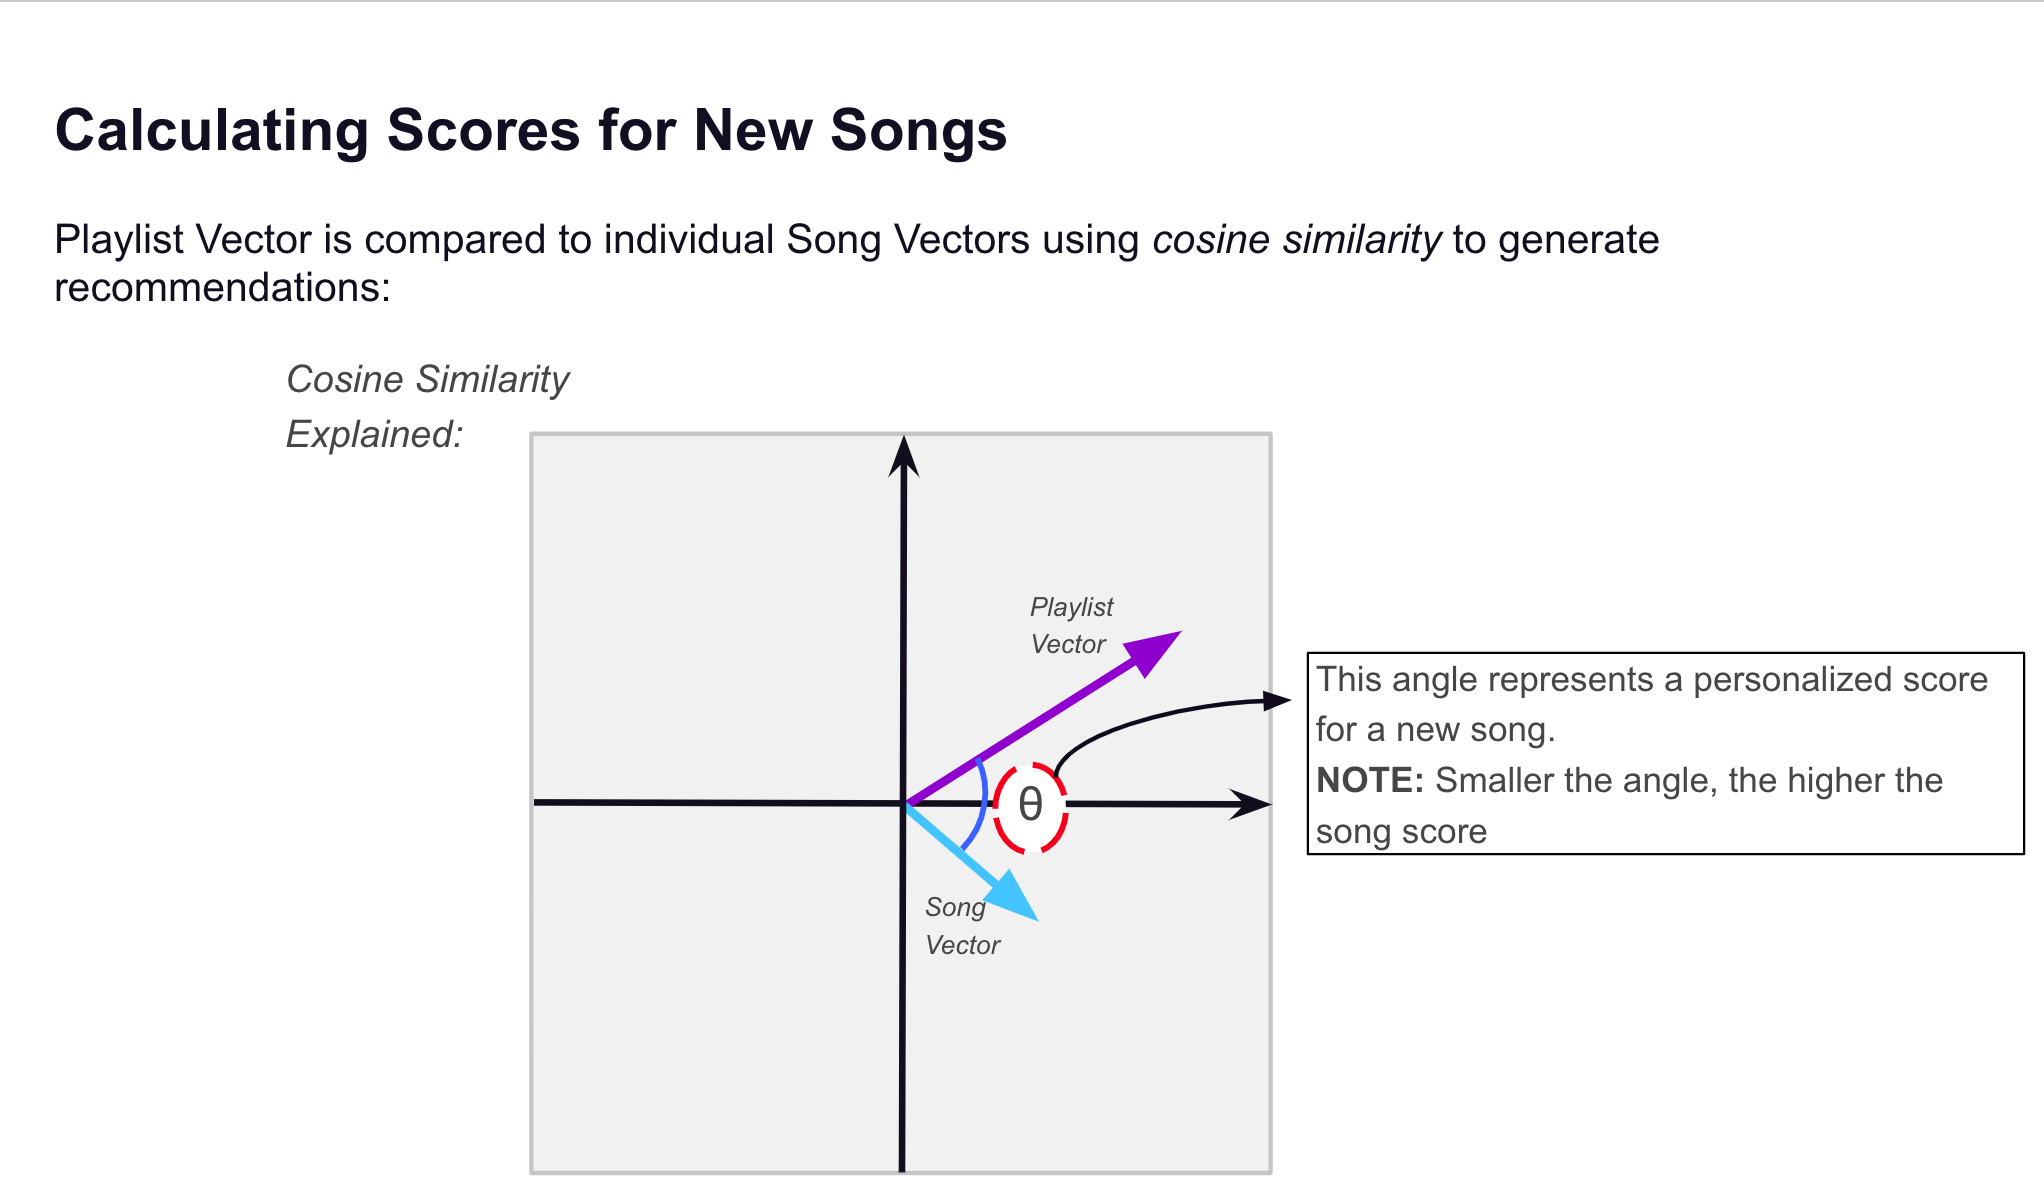

In [57]:
from IPython.display import Image
Image("cosine_sim_2.png")

In [58]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [59]:
edm_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM)

In [60]:
edm_top40

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red,sim,url
137421,0.05110,"['Cardi B', 'Migos']",0.968,262308,0.589,1,2qcG0nZ6S3zZV0UrkY5nFo,0.000000,11,0.0731,...,0.2680,2018,"[Cardi B, Migos]",[],"[Cardi B, Migos]",Cardi BDrip (feat. Migos),"[pop_rap, pop, atl_hip_hop, hip_hop, trap, rap...",12,0.721812,https://i.scdn.co/image/ab67616d00001e02a0caff...
157358,0.02350,"['A Boogie Wit da Hoodie', 'Tyga', 'Offset']",0.736,192779,0.622,1,0jAfdqv18goRTUxm3ilRjb,0.000000,6,0.1510,...,0.5060,2018,"[A Boogie Wit da Hoodie, Tyga, Offset]",[],"[A Boogie Wit da Hoodie, Tyga, Offset]",A Boogie Wit da HoodieStartender (feat. Offset...,"[pop_rap, atl_hip_hop, hip_hop, melodic_rap, s...",13,0.715524,https://i.scdn.co/image/ab67616d00001e02dcfade...
137424,0.00111,"['Cardi B', '21 Savage']",0.908,224285,0.524,1,0dIoGTQXDh1wVnhIiSyYEa,0.000678,1,0.3830,...,0.1090,2018,"[Cardi B, 21 Savage]",[],"[Cardi B, 21 Savage]",Cardi BBartier Cardi (feat. 21 Savage),"[pop_rap, pop, atl_hip_hop, trap, rap, dance_pop]",14,0.702283,https://i.scdn.co/image/ab67616d00001e02a0caff...
34975,0.66000,"['Social House', 'Lil Yachty']",0.769,164640,0.479,0,2Yer0p7uB2lVBUAtANuuQp,0.000000,1,0.0914,...,0.8030,2018,"[Social House, Lil Yachty]",[],"[Social House, Lil Yachty]",Social HouseMagic In The Hamptons (feat. Lil Y...,"[pop_rap, atl_hip_hop, hip_hop, melodic_rap, s...",15,0.702026,https://i.scdn.co/image/ab67616d00001e02013314...
30167,0.27200,"['T-Pain', 'B.o.B']",0.763,231893,0.530,1,1uH1Nd8vet2uoZSDFSDwbh,0.000000,5,0.1600,...,0.4690,2013,"[T-Pain, B.o.B]",[],"[T-Pain, B.o.B]",T-PainUp Down (Do This All Day) (feat. B.o.B),"[pop_rap, pop, r&b, atl_hip_hop, hip_hop, sout...",12,0.698879,https://i.scdn.co/image/ab67616d00001e02ea2602...
64403,0.36800,"['Metro Boomin', 'Gunna']",0.901,203267,0.464,1,1fewSx2d5KIZ04wsooEBOz,0.000017,5,0.2380,...,0.6380,2018,"[Metro Boomin, Gunna]",[],"[Metro Boomin, Gunna]",Metro BoominSpace Cadet (feat. Gunna),"[pop_rap, atl_hip_hop, hip_hop, melodic_rap, t...",16,0.697167,https://i.scdn.co/image/ab67616d00001e022887f8...
56144,0.22800,"['Offset', 'Cardi B']",0.919,205803,0.622,1,59ywHNwwchG4nZJMLyxSzd,0.000004,1,0.1220,...,0.4240,2019,"[Offset, Cardi B]",[],"[Offset, Cardi B]",OffsetClout (feat. Cardi B),"[pop_rap, pop, atl_hip_hop, hip_hop, trap, rap...",14,0.697020,https://i.scdn.co/image/ab67616d00001e02702867...
148467,0.13200,"['B.o.B', '2 Chainz']",0.919,220240,0.506,1,2LvRR121MWFmmEGkuV2vQP,0.000000,1,0.0771,...,0.2730,2013,"[B.o.B, 2 Chainz]",[],"[B.o.B, 2 Chainz]",B.o.BHeadBand (feat. 2 Chainz),"[pop_rap, pop, atl_hip_hop, hip_hop, pop_dance...",13,0.694507,https://i.scdn.co/image/ab67616d00001e0236ccb9...
129981,0.00218,"['DJ Khaled', 'Cardi B', '21 Savage']",0.861,202625,0.666,1,1Hd2XLitkt1PYCWSbfF5qV,0.000000,8,0.2720,...,0.8530,2019,"[DJ Khaled, Cardi B, 21 Savage]",[],"[DJ Khaled, Cardi B, 21 Savage]",DJ KhaledWish Wish (feat. Cardi B & 21 Savage),"[pop_rap, pop, atl_hip_hop, hip_hop, southern_...",13,0.686002,https://i.scdn.co/image/ab67616d00001e02fa2741...
124599,0.10200,"['Doja Cat', 'Tyga']",0.786,203093,0.652,1,7f5trao56t7sB7f14QDTmp,0.000000,0,0.0697,...,0.4830,2019,"[Doja Cat, Tyga]",[],"[Doja Cat, Tyga]",Doja CatJuicy,"[pop_rap, pop, hip_hop, trap, rap, dance_pop]",14,0.684775,https://i.scdn.co/image/ab67616d00001e0282b243...
